Change C_s_n_0 from 28544 -> 28800, need to change below 28540, to avoid first step error at Home PC
CV from C/20 -> C/50  
change pos critical stress to 2e9, to reduce LAM_pos and associtaed LLI

In [40]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
def Overwrite_Initial_L_SEI_0_Neg_Porosity(Para_0,cap_loss):
    """
    This is to overwrite the initial negative electrode porosity
    and initial SEI thickness (inner, outer) to be consistent
    with the initial capacity loss
    """
    delta_Q_SEI = cap_loss * 3600
    V_SEI = Para_0["Negative outer SEI partial molar volume [m3.mol-1]"]
    # do this when finish updating
    F = 96485.3
    A = Para_0["Electrode width [m]"] * Para_0["Electrode height [m]"]
    z_SEI = Para_0["Negative ratio of lithium moles to SEI moles"]
    L_neg = Para_0["Negative electrode thickness [m]"]
    eps_act_neg = Para_0["Negative electrode active material volume fraction"]
    R_neg =   Para_0["Negative particle radius [m]"]
    l_cr_init = Para_0["Negative electrode initial crack length [m]"]
    w_cr = Para_0["Negative electrode initial crack width [m]"]
    rho_cr = Para_0["Negative electrode number of cracks per unit area [m-2]"]
    a_neg = (3 * eps_act_neg / R_neg)
    roughness = 1 + 2 * l_cr_init * w_cr * rho_cr
    L_SEI_init = delta_Q_SEI  * V_SEI / (
        z_SEI * F * A * L_neg * a_neg * roughness)
 
    delta_epi = (L_SEI_init ) * roughness * a_neg
    L_inner_init = L_SEI_init / 2
    epi = 0.25 - delta_epi
    # print(L_inner_init,epi)
    # important: update here!
    Para_0["Negative electrode porosity"] = epi
    Para_0["Negative initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Negative initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    ## add Xinlei
    Para_0["Initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
 
    return Para_0

param = pybamm.ParameterValues("OKane2023_Xinlei")

Overwrite_Initial_L_SEI_0_Neg_Porosity(param,0.15)

Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah
Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah


{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': <function electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant at 0x7f6311de8b80>,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0.013,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x7f6311dd9e50>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'EC partial molar volume [m3.mol-1]': 6.667e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant at 0x7f6311de8d30>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diff

In [41]:
print(param["Negative electrode partial molar volume [m3.mol-1]"])
print(param["Negative electrode critical stress [Pa]"])
param["Negative electrode critical stress [Pa]"] = 6e8
print(param["Negative electrode critical stress [Pa]"])

3.1e-06
60000000.0
600000000.0


In [42]:
print(param["Positive electrode partial molar volume [m3.mol-1]"])
print(param["Positive electrode critical stress [Pa]"])

7.88e-07
2000000000.0


In [43]:
print(param["Initial concentration in negative electrode [mol.m-3]"])
param["Initial concentration in negative electrode [mol.m-3]"] = 28540
print(param["Initial concentration in negative electrode [mol.m-3]"])

28800
28540


In [44]:
print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])

D_sol = 7e-21
param["Outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Positive outer SEI solvent diffusivity [m2.s-1]"] = D_sol
param["Negative outer SEI solvent diffusivity [m2.s-1]"] = D_sol

print(param["Outer SEI solvent diffusivity [m2.s-1]"])
print(param["Positive outer SEI solvent diffusivity [m2.s-1]"])
print(param["Negative outer SEI solvent diffusivity [m2.s-1]"])

2.5000000000000002e-22
2.5000000000000002e-22
2.5000000000000002e-22
7e-21
7e-21
7e-21


In [45]:
# 从sol中计算循环过程中的容量，需要调整step如果换了工步
def calculate_capacities(sol):
    # 初始化充电容量和放电容量列表
    charge_capacities = []
    discharge_capacities = []

    # 遍历sol数据结构中的每个循环
    for cycle in sol.cycles:
        # 获取第一个步骤的放电容量时间序列
        step1_times = cycle.steps[0]["Discharge capacity [A.h]"].entries
        # 获取第二个步骤的放电容量时间序列
        step2_times = cycle.steps[1]["Discharge capacity [A.h]"].entries
        # 获取第三个步骤的放电容量时间序列
        step3_times = cycle.steps[2]["Discharge capacity [A.h]"].entries

        # 计算第一个步骤的初始值和第二个步骤的最后值的差（充电容量）
        charge_capacity = step2_times[-1] - step1_times[0]
        charge_capacities.append((-1) * charge_capacity)
        
        # 计算第三步的初始值和最后值的差（放电容量）
        discharge_capacity = step3_times[-1] - step3_times[0]
        discharge_capacities.append(discharge_capacity)

    # 返回计算结果
    return charge_capacities, discharge_capacities

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cwd = os.getcwd()


# 读取 pickle 文件
#pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
cycles_df = pd.read_pickle(pickle_file_path)
print("DataFrame loaded from pickle file")
print(cycles_df.head())


# 提取每个循环的最后一个 Q_dis 和 Q_cha 非零值
summary_data = []

for cycle in cycles_df.index.levels[0]:
    cycle_data = cycles_df.loc[cycle]
    last_q_dis = cycle_data[cycle_data['Q_dis'] > 0]['Q_dis'].iloc[-1] if not cycle_data[cycle_data['Q_dis'] > 0].empty else 0
    last_q_cha = cycle_data[cycle_data['Q_cha'] > 0]['Q_cha'].iloc[-1] if not cycle_data[cycle_data['Q_cha'] > 0].empty else 0
    summary_data.append([cycle, last_q_cha, last_q_dis])

# 创建一个新的 DataFrame 存储结果
summary_df = pd.DataFrame(summary_data, columns=['Cycle', 'Last_Q_cha', 'Last_Q_dis'])




DataFrame loaded from pickle file
            Mode  RelativeTime   Voltage          I  Q_dis     Q_cha  \
Cycle Step                                                             
1     1      1.0        0.0000  2.680430  1407.8055    0.0  0.000078   
      2      1.0        0.0084  2.690530  1574.4427    0.0  0.003691   
      3      1.0        0.0294  2.700598  1640.2499    0.0  0.013108   
      4      1.0        0.0634  2.710643  1664.4644    0.0  0.028749   
      5      1.0        0.1074  2.720645  1668.5892    0.0  0.049123   

                 Cap         R    Pressure  Temperature  
Cycle Step                                               
1     1     0.000078  1.903978  159.026607      25.3794  
      2     0.003691  1.708878  158.944819      25.3885  
      3     0.013108  1.646455  158.998347      25.4014  
      4     0.028749  1.628537  159.049016      25.4088  
      5     0.049123  1.630506  158.990980      25.4014  


In [47]:
model = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        "SEI": "solvent-diffusion limited",
        #"SEI": "interstitial-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")

var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 10,  # separator
    "x_p": 10,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

cycle_number = 20
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# exp = pybamm.Experiment(
#     [
#         "Hold at 4.2 V until C/100 (5 minute period)",
#         "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
#         "Charge at 0.1C until 4.2 V (5 minute period)",
#         "Hold at 4.2 V until C/100 (5 minute period)",
#     ]
# )


sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts )
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve(initial_soc=0)
#sol = sim.solve()


At t = 63.6142 and h = 8.2984e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 63.6132 and h = 9.96388e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 63.6141 and h = 1.14428e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.6717 and h = 9.11705e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.6708 and h = 1.79664e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.6718 and h = 4.57844e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.6717 and h = 2.3741e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 54.6531 and h = 8.65512e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 54.6533 and h = 5.20492e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 54.6529 and h = 2.06804e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

In [48]:
model_RPT = model.set_initial_conditions_from(sol)
exp_RPT = pybamm.Experiment(
    [
        "Hold at 2.5 V for 1 hours",
        "Charge at 0.1C until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Discharge at 0.1C until 2.5 V",
    ]
)

sim_RPT = pybamm.Simulation(model_RPT, parameter_values=param, experiment=exp_RPT, var_pts=var_pts )
sol_RPT_1 = sim_RPT.solve() 

At t = 519.131 and h = 6.46859e-11, the corrector convergence failed repeatedly or with |h| = hmin.


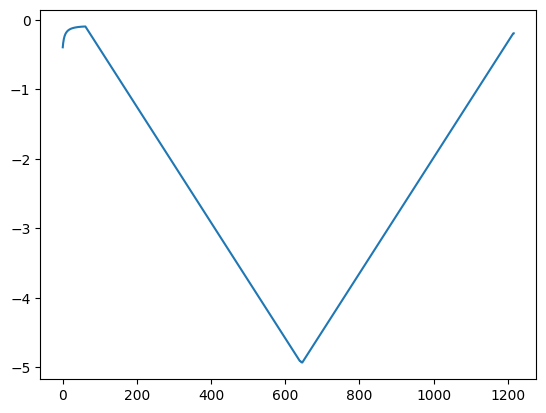

In [49]:
plt.plot(sol_RPT_1["Discharge capacity [A.h]"].entries)

In [50]:
model_RPT_0 = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        "SEI": "solvent-diffusion limited",
        #"SEI": "interstitial-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)
exp_RPT_0 = pybamm.Experiment(
    [
        "Charge at 0.1C until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Discharge at 0.1C until 2.5 V",
    ]
)
sim_RPT_0 = pybamm.Simulation(model_RPT_0, parameter_values=param, experiment=exp_RPT_0, var_pts=var_pts )
sol_RPT_0 = sim_RPT_0.solve(initial_soc=0)



At t = 480.199 and h = 2.05284e-10, the corrector convergence failed repeatedly or with |h| = hmin.


In [51]:
Cap_RPT_0 =np.max(sol_RPT_0["Discharge capacity [A.h]"].entries) - \
            np.min(sol_RPT_0["Discharge capacity [A.h]"].entries)

print(Cap_RPT_0)

Cap_RPT_1st =np.max(sol_RPT_1["Discharge capacity [A.h]"].entries) - \
            np.min(sol_RPT_1["Discharge capacity [A.h]"].entries)

print(Cap_RPT_1st)

SOH = Cap_RPT_1st/Cap_RPT_0 * 100

print("SOH = ",SOH,"%")

4.935644541291681
4.840225834363298
SOH =  98.06674272974666 %


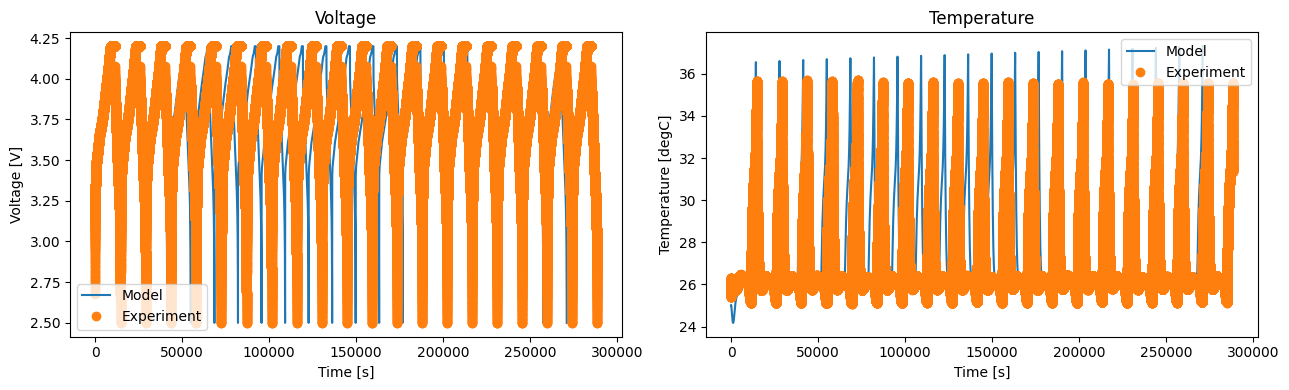

In [52]:
# 假设 `cycles_df` 是一个字典，其中的键是循环编号，每个键对应的值是包含该循环数据的DataFrame。

# 初始化空的DataFrame来存储合并后的电压和温度数据
merged_voltage = pd.DataFrame()
merged_temperature = pd.DataFrame()

# 初始化空的DataFrame来存储合并后的相对时间
merged_cycles_time = pd.DataFrame()

# 基准时间，从第一个循环的第一个数据点开始
base_time = cycles_df.loc[1]["RelativeTime"].iloc[0]

# 合并前20个循环
for i in range(1, 21):
    # 调整时间以基于第一个循环的起始时间
    adjusted_time = cycles_df.loc[i]["RelativeTime"] - base_time
    
    # 将调整后的时间添加到时间DataFrame中
    merged_cycles_time = pd.concat([merged_cycles_time, adjusted_time], ignore_index=True)
    
    # 将电压数据添加到电压DataFrame中
    merged_voltage = pd.concat([merged_voltage, cycles_df.loc[i]["Voltage"]], ignore_index=True)
    
    # 将温度数据添加到温度DataFrame中
    merged_temperature = pd.concat([merged_temperature, cycles_df.loc[i]["Temperature"]], ignore_index=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(t_sol, sol["Voltage [V]"](t_sol))
ax1.plot(merged_cycles_time, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(merged_cycles_time, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [53]:
def calculate_capacities(sol):
    # 初始化充电容量和放电容量列表
    charge_capacities = []
    discharge_capacities = []

    # 遍历sol数据结构中的每个循环
    for cycle in sol.cycles:
        # 获取第一个步骤的放电容量时间序列
        step1_times = cycle.steps[0]["Discharge capacity [A.h]"].entries
        # 获取第二个步骤的放电容量时间序列
        step2_times = cycle.steps[1]["Discharge capacity [A.h]"].entries
        # 获取第三个步骤的放电容量时间序列
        step3_times = cycle.steps[2]["Discharge capacity [A.h]"].entries

        # 计算第一个步骤的初始值和第二个步骤的最后值的差（充电容量）
        charge_capacity = step2_times[-1] - step1_times[0]
        charge_capacities.append((-1) * charge_capacity)
        
        # 计算第三步的初始值和最后值的差（放电容量）
        discharge_capacity = step3_times[-1] - step3_times[0]
        discharge_capacities.append(discharge_capacity)

    # 返回计算结果
    return charge_capacities, discharge_capacities

# 假设 sol 已定义并包含需要的数据
# 调用函数并接收结果
charge_capacities, discharge_capacities = calculate_capacities(sol)

# 输出结果
print("充电容量:", charge_capacities)
print("放电容量:", discharge_capacities)


充电容量: [4.929533451309574, 4.606314006808467, 4.599386126277685, 4.593732731681733, 4.588757206781122, 4.584225899507296, 4.580012339567769, 4.576041913664358, 4.572264944405176, 4.568643489458328, 4.565151438266249, 4.561766637626012, 4.5584742043537005, 4.5552621929735455, 4.5521144653539825, 4.549031407188105, 4.54600180415085, 4.543018221603429, 4.540074259147113, 4.537164547337859]
放电容量: [4.606462238170002, 4.599507718128411, 4.593842411413103, 4.588860489060376, 4.5843251675490935, 4.580109067367544, 4.576137001291875, 4.572359069930551, 4.5687369700129725, 4.5652448506204815, 4.561860111836566, 4.55856808062264, 4.555356685764316, 4.552209850366747, 4.549127831024141, 4.546099701758706, 4.543117557695772, 4.540175305631529, 4.537267541457236, 4.534390940516214]


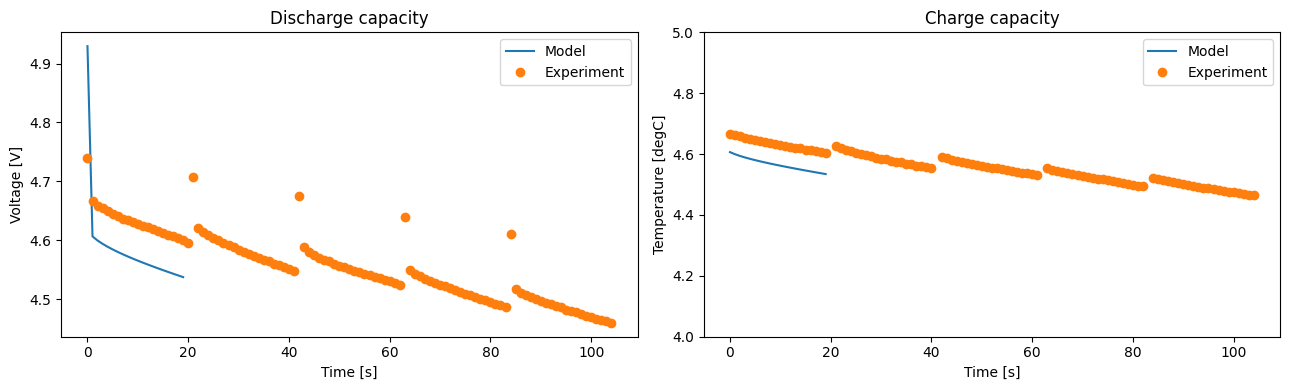

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(charge_capacities)
ax1.plot(summary_df["Last_Q_cha"]/1000, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Discharge capacity")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(discharge_capacities)
ax2.plot(summary_df["Last_Q_dis"]/1000, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Charge capacity")
ax2.set_ylim(4,5)
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

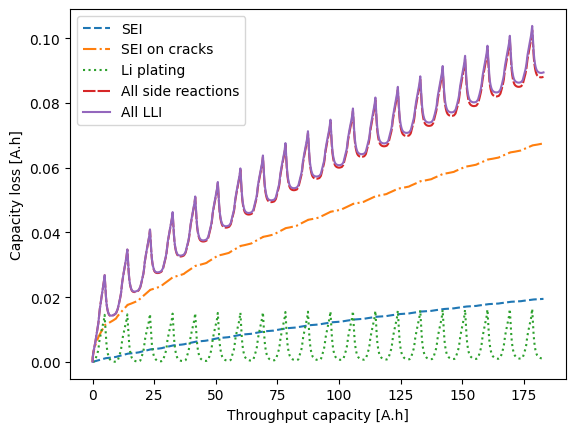

In [55]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries

#Q_particle = sol["Total lithium lost from particles [mol]"].entries * 96485.3 / 3600

Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
#plt.plot(Qt,Q_particle,label = "Particle")
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
#plt.xlim(0,25)
plt.ylabel("Capacity loss [A.h]")
#plt.ylim(0,0.03)
plt.legend()
plt.show()

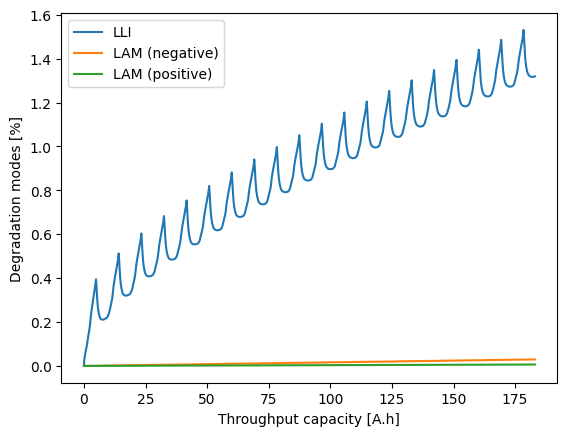

In [56]:
Qt = sol["Throughput capacity [A.h]"].entries
LLI = sol["Loss of lithium inventory [%]"].entries
LAM_neg = sol["Loss of active material in negative electrode [%]"].entries
LAM_pos = sol["Loss of active material in positive electrode [%]"].entries
plt.figure()
plt.plot(Qt, LLI, label="LLI")
plt.plot(Qt, LAM_neg, label="LAM (negative)")
plt.plot(Qt, LAM_pos, label="LAM (positive)")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Degradation modes [%]")
plt.legend()
plt.show()

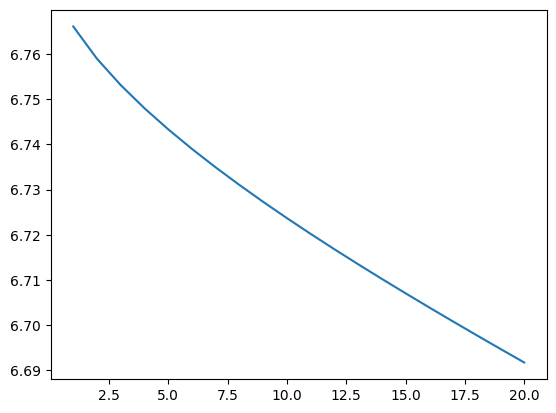

In [57]:
plt.plot(sol.summary_variables["Cycle number"],sol.summary_variables["Cyclable lithium capacity [A.h]"])


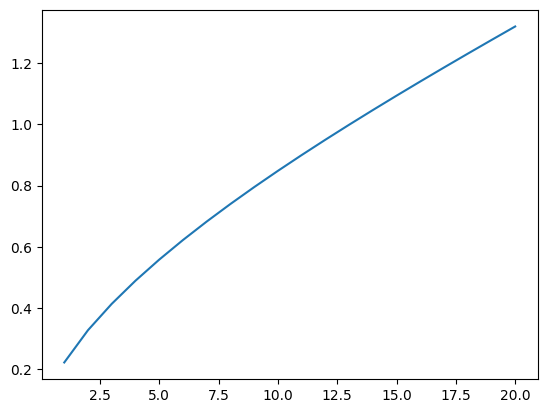

In [58]:
plt.plot(sol.summary_variables["Cycle number"],sol.summary_variables["Loss of lithium inventory [%]"])

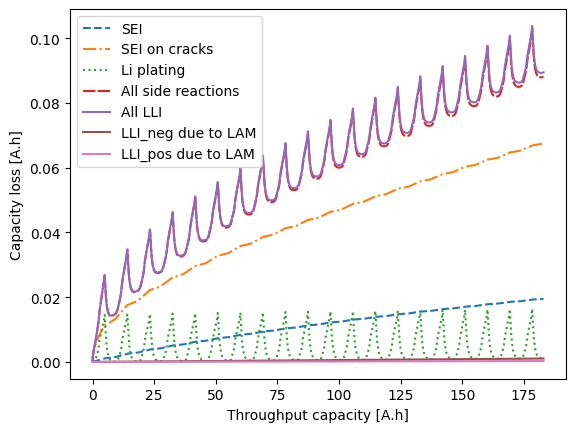

In [59]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

Q_LLI_due2_LAM_neg = (
    sol["Loss of lithium due to loss of active material in negative electrode [mol]"].entries * 96485.3 / 3600
)
Q_LLI_due2_LAM_pos = (
    sol["Loss of lithium due to loss of active material in positive electrode [mol]"].entries * 96485.3 / 3600
)
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.plot(Qt, Q_LLI_due2_LAM_neg, label="LLI_neg due to LAM")
plt.plot(Qt, Q_LLI_due2_LAM_pos, label="LLI_pos due to LAM")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

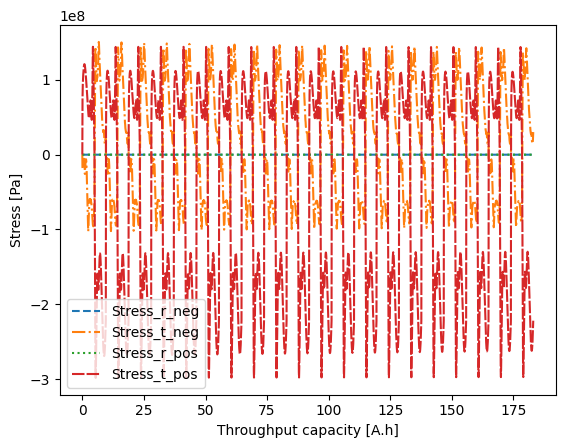

In [60]:
Qt = sol["Throughput capacity [A.h]"].entries
Stress_r_neg = sol["X-averaged negative particle surface radial stress [Pa]"].entries
Stress_t_neg = sol["X-averaged negative particle surface tangential stress [Pa]"].entries
Stress_r_pos = sol["X-averaged positive particle surface radial stress [Pa]"].entries
Stress_t_pos = sol["X-averaged positive particle surface tangential stress [Pa]"].entries
plt.figure()
plt.plot(Qt, Stress_r_neg, label="Stress_r_neg", linestyle="dashed")
plt.plot(Qt, Stress_t_neg, label="Stress_t_neg", linestyle="dashdot")
plt.plot(Qt, Stress_r_pos, label="Stress_r_pos", linestyle="dotted")
plt.plot(Qt, Stress_t_pos, label="Stress_t_pos", linestyle=(0, (6, 1)))

plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Stress [Pa]")
plt.legend()
plt.show()